In [1]:
import os
import numpy as np
import tensorflow as tf
import cv2
import albumentations as A
import mlflow

## __Sommaire__

1. __Introduction__ courte
- Objectif du dataset
- Structure en leftImg8bit/ et gtFine/
2. __Exemple__ de structure
- Afficher le chemin vers une image et son masque
- Lister les fichiers associés (os.listdir())
3. __Affichage__ : une image + son masque (labelIds)
- Masque brut
- Masque recolorisé (mapping palette)
4. __Analyse__ du contenu 
- `np.unique(mask)`
5. __Conclusion__
- Justification : pourquoi *_labelIds.png seulement
- Ce qu’on va en faire (générateur + modèle)

## 1. __Introduction__

Cityscapes est un __dataset très riche__, conçu à l’origine pour la recherche.  
Pour chaque __image de rue__ (fichier `leftImg8bit`), il existe __plusieurs fichiers associés__ dans `gtFine/` :

| Type de fichier                      | Nom typique                  | Utilité                                                                     | A garder ? |
| ------------------------------------ | ---------------------------- | --------------------------------------------------------------------------- | ----------- |
| Masque “numérique” par classe     | `xxx_gtFine_labelIds.png`    | Chaque pixel a un __ID de classe__                                          | ✅ Oui          |
| Masque coloré (joli mais inutile) | `xxx_gtFine_color.png`       | Chaque pixel est coloré (RGB), mais __pas exploitable pour l’entraînement__ | ❌ Non          |
| Masque par instance               | `xxx_gtFine_instanceIds.png` | Pour détecter chaque objet séparément (ex : 2 voitures distinctes)          | ❌ Non          |
| Fichier JSON (polygones)          | `xxx_gtFine_polygons.json`   | Utilisé pour reconstruire les masques, mais nous les avons déjà en `.png`  | ❌ Non          |


## 2. __Exemple__ 

Concrètement, pour une image d'entrée `aachen_000000_000019_leftImg8bit.png`, nous trouverons les fichiers suivants dans `gtFine/train/aachen/` :
- `aachen_000000_000019_gtFine_labelIds.png`       ← ✅ masque qu’on utilisera
- `aachen_000000_000019_gtFine_color.png`          ← ❌ joli mais inutile
- `aachen_000000_000019_gtFine_instanceIds.png`    ← ❌ utile pour détection, pas ici
- `aachen_000000_000019_gtFine_polygons.json`      ← ❌ sert à reconstruire les masques  

__Pourquoi on garde `*_labelIds.png` ?__
- Chaque pixel est un entier : 0, 1, 2, ..., jusqu’à 33 (→ 34 classes possibles)
- On peut facilement transformer ces entiers en couleurs, en masques, en classes
- C’est le format qu’attendent les fonctions Keras / TensorFlow pour l’entraînement

In [4]:
# Lister les fichiers pour une ville (ex : aachen)
sample_img_dir = "../data/raw/leftImg8bit/train/aachen"
sample_mask_dir = "../data/raw/gtFine/train/aachen"

print("Fichiers image :")
print(os.listdir(sample_img_dir)[:5])  # juste 5 exemples

print("\n Fichiers masques :")
print([f for f in os.listdir(sample_mask_dir) if "labelIds" in f][:5])


Fichiers image :
['aachen_000079_000019_leftImg8bit.png', 'aachen_000073_000019_leftImg8bit.png', 'aachen_000100_000019_leftImg8bit.png', 'aachen_000006_000019_leftImg8bit.png', 'aachen_000037_000019_leftImg8bit.png']

 Fichiers masques :
['aachen_000002_000019_gtFine_labelIds.png', 'aachen_000141_000019_gtFine_labelIds.png', 'aachen_000037_000019_gtFine_labelIds.png', 'aachen_000018_000019_gtFine_labelIds.png', 'aachen_000014_000019_gtFine_labelIds.png']


## 3. __Affichage__

Image path: True
Mask path: True


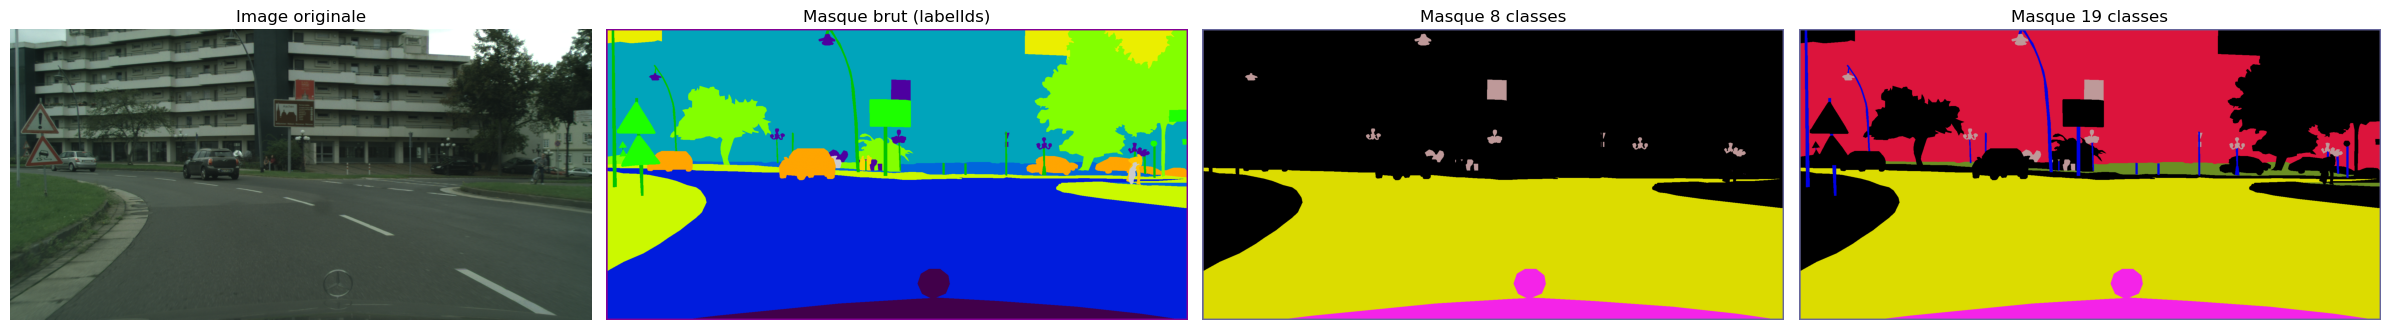

In [5]:
import matplotlib.pyplot as plt

# Répertoires relatifs depuis notebooks/
IMG_DIR = "../data/raw/leftImg8bit/train/aachen"
MASK_DIR = "../data/raw/gtFine/train/aachen"

# Fichier choisi
base_filename = "aachen_000000_000019"

# Chemins complets
image_path = os.path.join(IMG_DIR, base_filename + "_leftImg8bit.png")
mask_path = os.path.join(MASK_DIR, base_filename + "_gtFine_labelIds.png")

# Vérification d'existence
print("Image path:", os.path.exists(image_path))
print("Mask path:", os.path.exists(mask_path))

# Chargement image + masque
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image non trouvée à ce chemin : {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

# Palette simplifiée (8 classes principales)
CITYSCAPES_COLORS = {
    0: (128, 64,128),  # road
    1: (244, 35,232),  # sidewalk
    2: ( 70, 70, 70),  # building
    3: (102,102,156),  # wall
    4: (190,153,153),  # fence
    5: (153,153,153),  # pole
    6: (250,170, 30),  # traffic light
    7: (220,220,  0),  # traffic sign
}

# Palette complète (19 classes)
CITYSCAPES_TRAINID_TO_COLOR = {
    0:  (128,  64, 128),  # road
    1:  (244,  35, 232),  # sidewalk
    2:  ( 70,  70,  70),  # building
    3:  (102, 102, 156),  # wall
    4:  (190, 153, 153),  # fence
    5:  (153, 153, 153),  # pole
    6:  (250, 170,  30),  # traffic light
    7:  (220, 220,   0),  # traffic sign
    8:  (107, 142,  35),  # vegetation
    9:  (152, 251, 152),  # terrain
    10: ( 70, 130, 180),  # sky
    11: (220,  20,  60),  # person
    12: (255,   0,   0),  # rider
    13: (  0,   0, 142),  # car
    14: (  0,   0,  70),  # truck
    15: (  0,  60, 100),  # bus
    16: (  0,  80, 100),  # train
    17: (  0,   0, 230),  # motorcycle
    18: (119,  11,  32),  # bicycle
}


def colorize_mask(mask, color_dict):
    """
    Convertit un masque labelIds en image RGB avec une palette donnée.
    """
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label_id, color in color_dict.items():
        color_mask[mask == label_id] = color
    return color_mask


# Coloriser avec palette 8 classes (déjà fait avant)
color_mask_8 = colorize_mask(mask, CITYSCAPES_COLORS)

# Coloriser avec palette 19 classes
color_mask_19 = colorize_mask(mask, CITYSCAPES_TRAINID_TO_COLOR)


# Affichage
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

axs[0].imshow(image)
axs[0].set_title("Image originale")
axs[0].axis("off")

axs[1].imshow(mask, cmap="nipy_spectral")
axs[1].set_title("Masque brut (labelIds)")
axs[1].axis("off")

axs[2].imshow(color_mask_8)
axs[2].set_title("Masque 8 classes")
axs[2].axis("off")

axs[3].imshow(color_mask_19)
axs[3].set_title("Masque 19 classes")
axs[3].axis("off")

plt.tight_layout()
plt.show()



## 4. __Analyse__

Comme déjà expliqué : quand on charges un masque `*_labelIds.png`, chaque pixel contient __un nombre entier__ correspondant à une classe (label ID).  
`np.unique(mask)` va nous permettre de :
- Lister __toutes les classes présentes dans une image__
- Vérifier que le masque est bien lu (pas vide ou erroné)
- Préparer le mapping 34 → 8 classes
- Diagnostiquer les cas “masque tout noir”

In [6]:
# Analyse des classes présentes dans le masque
unique_ids = np.unique(mask)
print(" Classes présentes dans ce masque :", unique_ids)
print(" Nombre de classes présentes :", len(unique_ids))


 Classes présentes dans ce masque : [ 0  1  3  4  7  8 11 17 20 21 22 23 24 25 26 33]
 Nombre de classes présentes : 16


## 5. __Conclusion__

On garde `*_labelIds.png` car :
- Chaque pixel est un entier : 0, 1, 2, ..., jusqu’à 33 (→ 34 classes possibles)
- C’est le format adapté aux fonctions Keras / TensorFlow pour l’entraînement
Le fichier `labelIds` contient donc les ID bruts (labelId), de 0 à 33... Mais Cityscapes utilise un __mapping vers des `trainId` de 0 à 18__ pour l’entraînement.
__Nous allons devoir mapper cela dans notre preprocessing `02_preprocess.ipynb`.__